# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.68KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

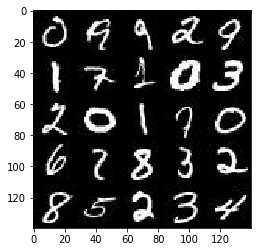

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

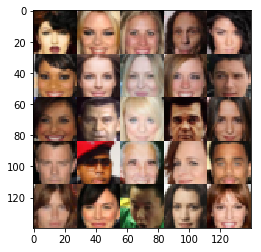

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
                
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
                
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
                
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
                
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations 
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)                

        saver.save(sess, './generator.ckpt')

    return losses                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 4.4007
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 2.9301
Epoch 1/2... Discriminator Loss: 1.9171... Generator Loss: 0.2835
Epoch 1/2... Discriminator Loss: 0.4678... Generator Loss: 2.8054
Epoch 1/2... Discriminator Loss: 0.4358... Generator Loss: 2.9187
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 2.1194
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.2020
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.8896
Epoch 1/2... Discriminator Loss: 1.2638... Generator Loss: 2.8431
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 2.1351


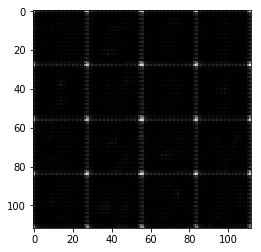

Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 2.4484
Epoch 1/2... Discriminator Loss: 0.7719... Generator Loss: 1.3956
Epoch 1/2... Discriminator Loss: 0.7259... Generator Loss: 1.2958
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 1.5080
Epoch 1/2... Discriminator Loss: 0.6722... Generator Loss: 1.3823
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 2.1035
Epoch 1/2... Discriminator Loss: 0.4049... Generator Loss: 3.1323
Epoch 1/2... Discriminator Loss: 0.3951... Generator Loss: 3.1455
Epoch 1/2... Discriminator Loss: 0.3484... Generator Loss: 4.6008
Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 4.2614


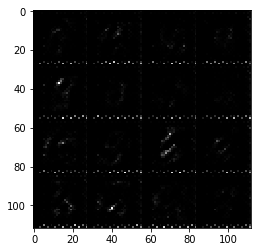

Epoch 1/2... Discriminator Loss: 0.3574... Generator Loss: 4.2079
Epoch 1/2... Discriminator Loss: 0.3505... Generator Loss: 4.8173
Epoch 1/2... Discriminator Loss: 0.3981... Generator Loss: 2.9875
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 3.4870
Epoch 1/2... Discriminator Loss: 3.1509... Generator Loss: 10.4685
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 2.6581
Epoch 1/2... Discriminator Loss: 0.3961... Generator Loss: 3.4031
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 4.1446
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 3.3286
Epoch 1/2... Discriminator Loss: 0.5703... Generator Loss: 1.7781


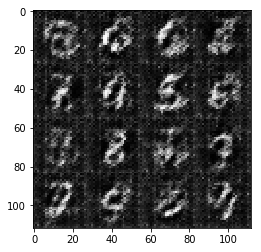

Epoch 1/2... Discriminator Loss: 0.4164... Generator Loss: 3.4824
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 4.8470
Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 7.0021
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 4.5860
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 3.6766
Epoch 1/2... Discriminator Loss: 0.9913... Generator Loss: 3.6460
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 4.9277
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 5.1357
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 4.6793
Epoch 1/2... Discriminator Loss: 0.4002... Generator Loss: 3.5073


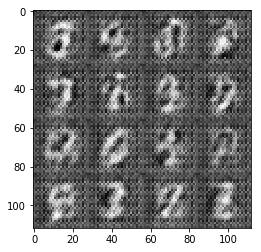

Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 2.8103
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.2675
Epoch 1/2... Discriminator Loss: 0.3778... Generator Loss: 3.4834
Epoch 1/2... Discriminator Loss: 0.3737... Generator Loss: 3.6983
Epoch 1/2... Discriminator Loss: 0.4285... Generator Loss: 2.6169
Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 3.6867
Epoch 1/2... Discriminator Loss: 0.3703... Generator Loss: 3.6908
Epoch 1/2... Discriminator Loss: 0.3345... Generator Loss: 6.4588
Epoch 1/2... Discriminator Loss: 0.3807... Generator Loss: 8.9282
Epoch 1/2... Discriminator Loss: 0.3398... Generator Loss: 7.4601


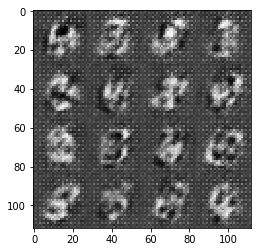

Epoch 1/2... Discriminator Loss: 0.3417... Generator Loss: 5.9629
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 4.7525
Epoch 1/2... Discriminator Loss: 0.4276... Generator Loss: 9.0835
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.4357
Epoch 1/2... Discriminator Loss: 0.7634... Generator Loss: 3.4201
Epoch 1/2... Discriminator Loss: 0.7747... Generator Loss: 1.2389
Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 2.7261
Epoch 1/2... Discriminator Loss: 0.3377... Generator Loss: 7.1998
Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 5.7507
Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 2.7223


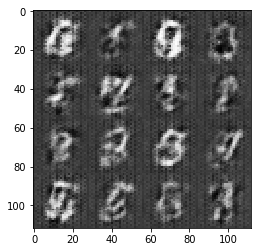

Epoch 1/2... Discriminator Loss: 0.3446... Generator Loss: 5.7996
Epoch 1/2... Discriminator Loss: 0.8420... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 10.1283
Epoch 1/2... Discriminator Loss: 0.5242... Generator Loss: 4.4872
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 5.6978
Epoch 1/2... Discriminator Loss: 0.4372... Generator Loss: 2.8646
Epoch 1/2... Discriminator Loss: 0.4723... Generator Loss: 2.2156
Epoch 1/2... Discriminator Loss: 0.3643... Generator Loss: 4.8176
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 6.1970
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 6.7290


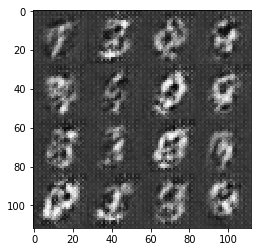

Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 0.4431... Generator Loss: 5.2136
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 3.9476
Epoch 1/2... Discriminator Loss: 0.4475... Generator Loss: 3.1948
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.5981
Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 3.9281
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 3.8019
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.6652
Epoch 1/2... Discriminator Loss: 0.3761... Generator Loss: 3.4900


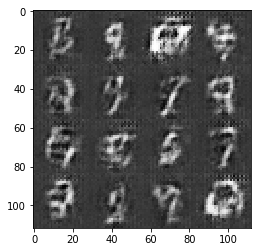

Epoch 1/2... Discriminator Loss: 0.3519... Generator Loss: 5.4403
Epoch 1/2... Discriminator Loss: 0.3394... Generator Loss: 5.6612
Epoch 1/2... Discriminator Loss: 0.4490... Generator Loss: 3.0150
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.3768
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 2.3312
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 2.1583
Epoch 1/2... Discriminator Loss: 0.4920... Generator Loss: 2.1102
Epoch 1/2... Discriminator Loss: 0.4938... Generator Loss: 2.0446
Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 2.3544


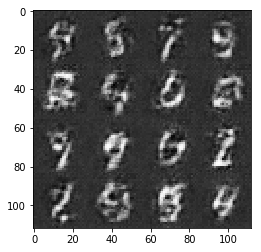

Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 1.9591
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 2.9261
Epoch 1/2... Discriminator Loss: 0.3834... Generator Loss: 3.4712
Epoch 2/2... Discriminator Loss: 0.3781... Generator Loss: 3.8960
Epoch 2/2... Discriminator Loss: 0.3735... Generator Loss: 4.9100
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 3.1595
Epoch 2/2... Discriminator Loss: 0.3652... Generator Loss: 3.8662
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 1.6435
Epoch 2/2... Discriminator Loss: 0.6845... Generator Loss: 1.8502
Epoch 2/2... Discriminator Loss: 0.6999... Generator Loss: 1.2929


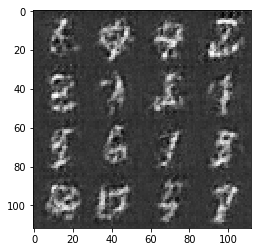

Epoch 2/2... Discriminator Loss: 0.3686... Generator Loss: 4.4433
Epoch 2/2... Discriminator Loss: 0.4373... Generator Loss: 4.3631
Epoch 2/2... Discriminator Loss: 0.3626... Generator Loss: 3.8551
Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 2.0449
Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 3.5852
Epoch 2/2... Discriminator Loss: 0.4499... Generator Loss: 2.3104
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.6003
Epoch 2/2... Discriminator Loss: 0.3481... Generator Loss: 4.5167
Epoch 2/2... Discriminator Loss: 0.8057... Generator Loss: 4.6347
Epoch 2/2... Discriminator Loss: 0.5283... Generator Loss: 2.0131


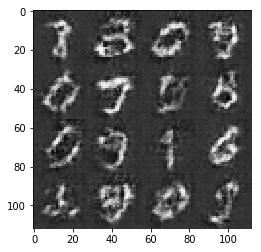

Epoch 2/2... Discriminator Loss: 0.4586... Generator Loss: 2.4837
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 3.1165
Epoch 2/2... Discriminator Loss: 0.4757... Generator Loss: 2.1857
Epoch 2/2... Discriminator Loss: 0.3802... Generator Loss: 3.3773
Epoch 2/2... Discriminator Loss: 0.3724... Generator Loss: 3.3690
Epoch 2/2... Discriminator Loss: 0.4332... Generator Loss: 2.5310
Epoch 2/2... Discriminator Loss: 0.3553... Generator Loss: 4.3701
Epoch 2/2... Discriminator Loss: 0.4103... Generator Loss: 3.5454
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 1.8630
Epoch 2/2... Discriminator Loss: 0.3953... Generator Loss: 3.1539


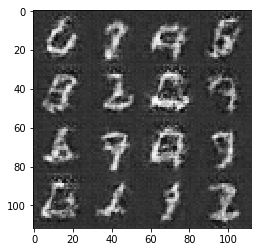

Epoch 2/2... Discriminator Loss: 0.3611... Generator Loss: 4.0268
Epoch 2/2... Discriminator Loss: 0.3537... Generator Loss: 4.2925
Epoch 2/2... Discriminator Loss: 0.3748... Generator Loss: 3.4602
Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 4.2171
Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 4.8190
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 1.8616
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.6315
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 5.6634
Epoch 2/2... Discriminator Loss: 2.7289... Generator Loss: 0.1499
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.8715


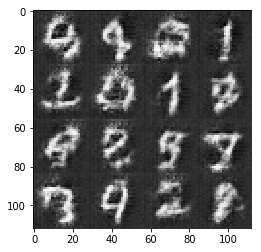

Epoch 2/2... Discriminator Loss: 1.5859... Generator Loss: 3.2151
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.5261
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.5026
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.8824
Epoch 2/2... Discriminator Loss: 0.5389... Generator Loss: 1.9894
Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.2665
Epoch 2/2... Discriminator Loss: 0.5043... Generator Loss: 1.9726
Epoch 2/2... Discriminator Loss: 0.4891... Generator Loss: 2.2433
Epoch 2/2... Discriminator Loss: 0.3696... Generator Loss: 3.5594


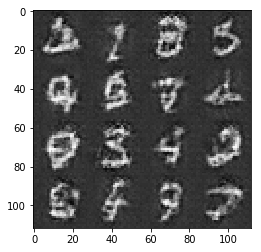

Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 3.7062
Epoch 2/2... Discriminator Loss: 0.5603... Generator Loss: 1.7296
Epoch 2/2... Discriminator Loss: 0.4978... Generator Loss: 5.2304
Epoch 2/2... Discriminator Loss: 0.4802... Generator Loss: 2.2335
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 2.7559
Epoch 2/2... Discriminator Loss: 0.3365... Generator Loss: 5.9187
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 3.3489
Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 4.9726
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 2.9612
Epoch 2/2... Discriminator Loss: 0.7481... Generator Loss: 1.2321


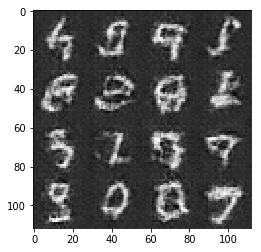

Epoch 2/2... Discriminator Loss: 0.6546... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 3.7329
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 1.8934
Epoch 2/2... Discriminator Loss: 0.3969... Generator Loss: 3.0150
Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 3.2296
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 3.0213
Epoch 2/2... Discriminator Loss: 0.3647... Generator Loss: 3.7638
Epoch 2/2... Discriminator Loss: 0.4122... Generator Loss: 2.7483
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.1985


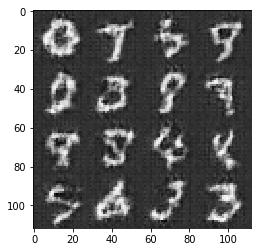

Epoch 2/2... Discriminator Loss: 0.4819... Generator Loss: 2.3973
Epoch 2/2... Discriminator Loss: 0.6169... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 0.3791... Generator Loss: 3.8231
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 3.5121
Epoch 2/2... Discriminator Loss: 0.4224... Generator Loss: 4.6077
Epoch 2/2... Discriminator Loss: 0.3619... Generator Loss: 3.7213
Epoch 2/2... Discriminator Loss: 0.3399... Generator Loss: 5.0547
Epoch 2/2... Discriminator Loss: 0.3384... Generator Loss: 5.4350
Epoch 2/2... Discriminator Loss: 0.3394... Generator Loss: 4.9678
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 6.3436


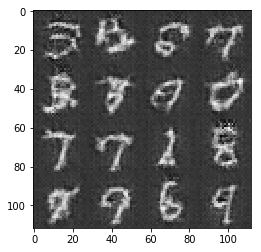

Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 6.0315
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 5.8229
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 8.2595
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 3.0001
Epoch 2/2... Discriminator Loss: 0.3589... Generator Loss: 3.7299
Epoch 2/2... Discriminator Loss: 0.3832... Generator Loss: 3.2763
Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 5.5189
Epoch 2/2... Discriminator Loss: 0.3689... Generator Loss: 3.4793
Epoch 2/2... Discriminator Loss: 0.3527... Generator Loss: 4.1060
Epoch 2/2... Discriminator Loss: 0.3402... Generator Loss: 5.6427


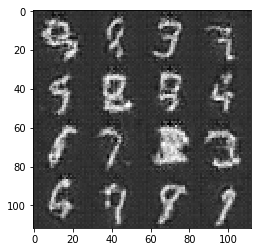

Epoch 2/2... Discriminator Loss: 0.3352... Generator Loss: 5.8611
Epoch 2/2... Discriminator Loss: 0.3894... Generator Loss: 3.1516
Epoch 2/2... Discriminator Loss: 0.3534... Generator Loss: 4.0016
Epoch 2/2... Discriminator Loss: 0.3490... Generator Loss: 5.4600
Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 4.5338
Epoch 2/2... Discriminator Loss: 0.3629... Generator Loss: 6.9634
Epoch 2/2... Discriminator Loss: 0.4041... Generator Loss: 3.0581


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 4.8101
Epoch 1/1... Discriminator Loss: 0.3861... Generator Loss: 3.5202
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 20.1499
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 9.4007
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 2.9511
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 4.0056
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 3.8796
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 4.5190
Epoch 1/1... Discriminator Loss: 0.4439... Generator Loss: 2.9161


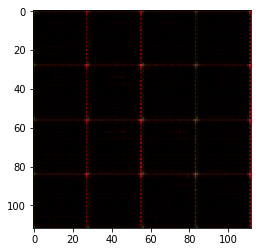

Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 3.0338
Epoch 1/1... Discriminator Loss: 0.3656... Generator Loss: 4.3716
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 4.8861
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.2591
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 5.8708
Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 7.0735
Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 4.5810
Epoch 1/1... Discriminator Loss: 0.3778... Generator Loss: 3.8533
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 3.4750
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.3502


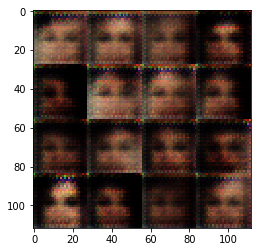

Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 2.2160
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.9400
Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 5.2121
Epoch 1/1... Discriminator Loss: 0.4514... Generator Loss: 3.1082
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.8429
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 2.9914
Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 5.3483
Epoch 1/1... Discriminator Loss: 0.5540... Generator Loss: 3.2842
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 3.0873


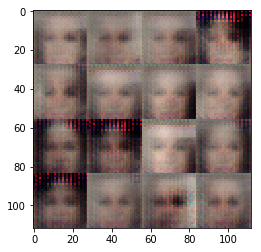

Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 3.7464
Epoch 1/1... Discriminator Loss: 0.3564... Generator Loss: 4.5598
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 4.6112
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 4.2902
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 2.9072
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 3.2460
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 4.1713


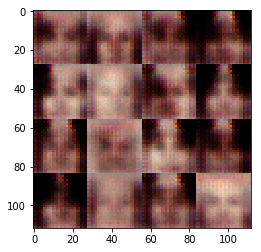

Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 2.4186
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 3.5934
Epoch 1/1... Discriminator Loss: 0.3956... Generator Loss: 3.4786
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.9745
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 4.9643
Epoch 1/1... Discriminator Loss: 3.8437... Generator Loss: 4.3380
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 4.0472
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 3.3229


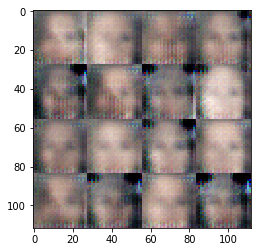

Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 3.1044
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 4.0817
Epoch 1/1... Discriminator Loss: 0.3838... Generator Loss: 3.8756
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.4894
Epoch 1/1... Discriminator Loss: 0.3467... Generator Loss: 5.4911
Epoch 1/1... Discriminator Loss: 0.3578... Generator Loss: 4.3438
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 3.1999
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 6.2730
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.7258


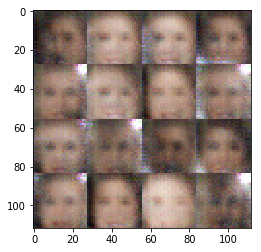

Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 3.8404
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 4.1574
Epoch 1/1... Discriminator Loss: 0.7110... Generator Loss: 1.4823
Epoch 1/1... Discriminator Loss: 0.3419... Generator Loss: 6.2084
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 5.9295
Epoch 1/1... Discriminator Loss: 0.3420... Generator Loss: 4.8579
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 3.6969
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 5.0694
Epoch 1/1... Discriminator Loss: 0.3465... Generator Loss: 4.9740
Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 11.4185


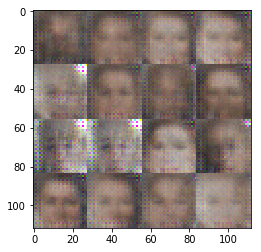

Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 3.8054
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 3.5921
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 2.9531
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 4.9407
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 3.0391
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 3.1562
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 3.7550
Epoch 1/1... Discriminator Loss: 0.4285... Generator Loss: 3.4263
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 6.0403
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.2434


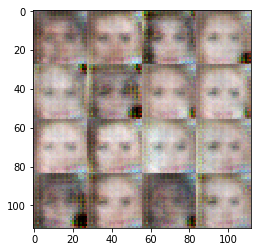

Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 0.8818... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 3.5553
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 6.0774
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 4.2304
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 2.6601
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.5010
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 4.3516
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.3496
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.7728


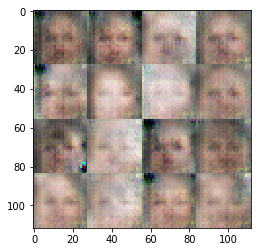

Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.4752
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 5.0258
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.5431
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.5184
Epoch 1/1... Discriminator Loss: 0.4788... Generator Loss: 2.3804
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.9369
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 6.5132
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.4324
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 1.4930


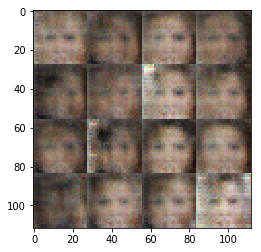

Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 4.1037
Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 5.5588
Epoch 1/1... Discriminator Loss: 4.8029... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 1.7583... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 2.1647... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.8287... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.4034


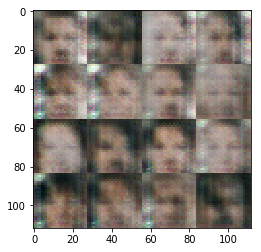

Epoch 1/1... Discriminator Loss: 3.2507... Generator Loss: 3.8923
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 0.4289... Generator Loss: 2.7623
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 2.3006
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 5.2294
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 3.8864


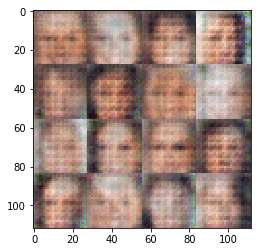

Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.4985
Epoch 1/1... Discriminator Loss: 2.0480... Generator Loss: 0.5647
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 2.9574
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.0407
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.4066


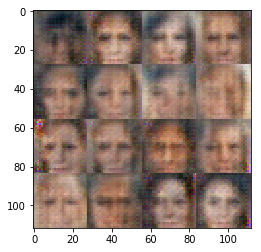

Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 2.4539
Epoch 1/1... Discriminator Loss: 0.6737... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.0740
Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 0.8324... Generator Loss: 1.1952


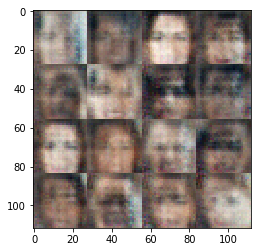

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 2.4275
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.7702
Epoch 1/1... Discriminator Loss: 1.6940... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 3.4366
Epoch 1/1... Discriminator Loss: 0.7428... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 4.7500


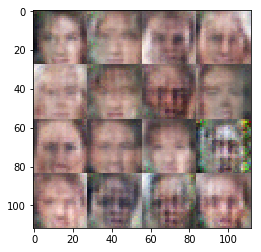

Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 5.4148
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 3.3182
Epoch 1/1... Discriminator Loss: 1.8963... Generator Loss: 0.3168
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 2.4827
Epoch 1/1... Discriminator Loss: 0.3329... Generator Loss: 7.6966
Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 4.9465


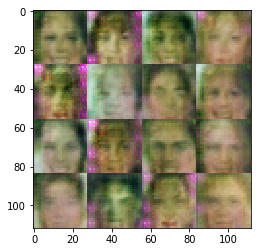

Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 0.4866... Generator Loss: 3.0131
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 3.8766
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.8005
Epoch 1/1... Discriminator Loss: 3.6490... Generator Loss: 3.7962
Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 4.1978
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 4.4724
Epoch 1/1... Discriminator Loss: 0.3370... Generator Loss: 7.7283
Epoch 1/1... Discriminator Loss: 2.6928... Generator Loss: 0.1753


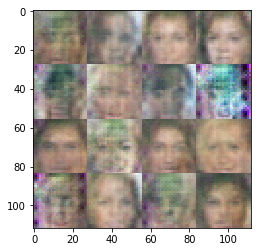

Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 2.3872
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 7.0545
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 4.2103
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 6.2474
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 3.7457
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 4.9923
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 8.3707
Epoch 1/1... Discriminator Loss: 0.3884... Generator Loss: 3.2908
Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 8.8024


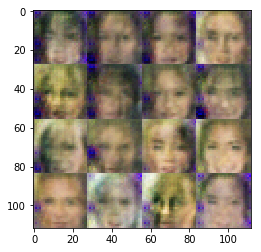

Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.1069
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 8.0679
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 6.7606
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.2603
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 5.0032
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 3.9498
Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 8.6078
Epoch 1/1... Discriminator Loss: 0.4314... Generator Loss: 2.6100


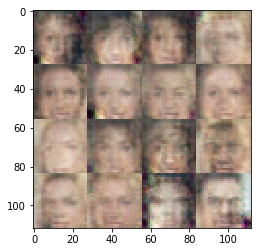

Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 7.0455
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 6.8334
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 8.1493
Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 10.3817
Epoch 1/1... Discriminator Loss: 0.4613... Generator Loss: 2.4093
Epoch 1/1... Discriminator Loss: 1.9453... Generator Loss: 4.0406
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 7.2702


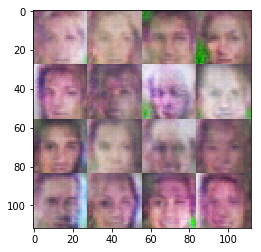

Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 8.1961
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 9.2446
Epoch 1/1... Discriminator Loss: 2.3123... Generator Loss: 0.1821
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 5.5597
Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 4.8408
Epoch 1/1... Discriminator Loss: 0.4468... Generator Loss: 2.3629
Epoch 1/1... Discriminator Loss: 0.4010... Generator Loss: 3.1368
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 0.4812... Generator Loss: 2.5038


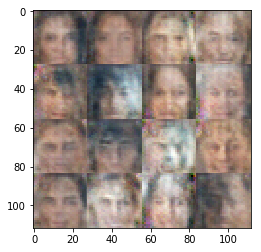

Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 7.7663
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 4.2715
Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.6536... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 0.3620... Generator Loss: 4.7482


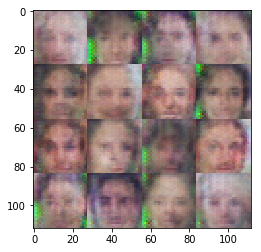

Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 2.5313
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 8.3481
Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 2.9653
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.3651... Generator Loss: 4.3704
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 7.0092
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 5.5548
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 2.9580


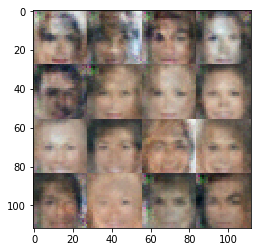

Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.2354
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 4.1738
Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 2.8386
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 5.2585
Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 8.9383
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.9670
Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 8.1896
Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 7.8758
Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 6.2485


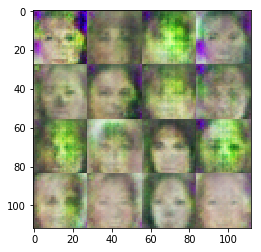

Epoch 1/1... Discriminator Loss: 0.3649... Generator Loss: 4.2377
Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 8.2985
Epoch 1/1... Discriminator Loss: 0.4091... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 8.3075
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.8526
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 0.3585... Generator Loss: 4.4381
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.8765
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 2.5082
Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 8.6596


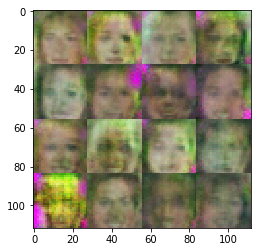

Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 3.7916
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 2.7731
Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.8449
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 5.8420
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.9559
Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 4.7749
Epoch 1/1... Discriminator Loss: 2.0530... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 4.4573
Epoch 1/1... Discriminator Loss: 1.5944... Generator Loss: 0.4337


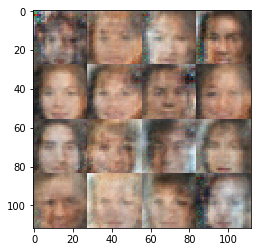

Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 1.9313
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 7.6321
Epoch 1/1... Discriminator Loss: 0.4746... Generator Loss: 3.9392
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 0.3416... Generator Loss: 6.3306
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 7.3813
Epoch 1/1... Discriminator Loss: 0.3828... Generator Loss: 5.5509
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 7.1212
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 4.8970
Epoch 1/1... Discriminator Loss: 0.4732... Generator Loss: 4.4872


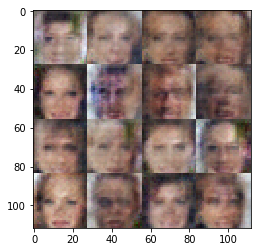

Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.3509
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.9392
Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8823


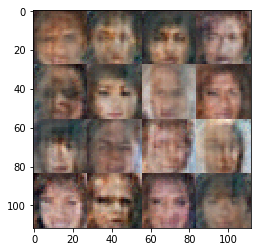

Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.7318... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8518


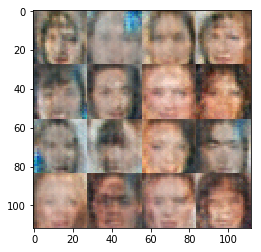

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.3295
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 3.1952
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 4.8513
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.6136
Epoch 1/1... Discriminator Loss: 0.6750... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 3.5700


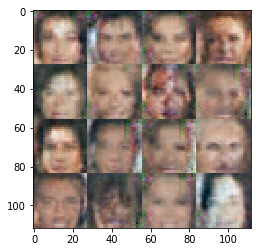

Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 4.1919
Epoch 1/1... Discriminator Loss: 1.5845... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.2785
Epoch 1/1... Discriminator Loss: 0.3675... Generator Loss: 6.2784
Epoch 1/1... Discriminator Loss: 0.4626... Generator Loss: 2.4397
Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 6.2378
Epoch 1/1... Discriminator Loss: 0.5906... Generator Loss: 2.3549
Epoch 1/1... Discriminator Loss: 0.5138... Generator Loss: 2.0692
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.5429


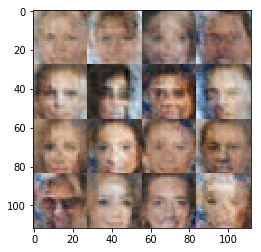

Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 4.3384
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 5.9826
Epoch 1/1... Discriminator Loss: 0.4223... Generator Loss: 2.7941
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 3.4765
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 6.6095


In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.